# 구글 코랩 사전 준비 
- 설치 후 재시작 필요

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
! pip install konlpy wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 한글 폰트 지정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()

[f for f in sys_font if 'Nanum' in f]

['/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf']

In [ ]:
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
font_name

'NanumBarunGothic'

In [ ]:
plt.rc('font', family=font_name)
fm._rebuild() 

FileNotFoundError: ignored

# Library

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

# Load Dataset

In [ ]:
# 네이버 영화 리뷰 데이터
file_path = tf.keras.utils.get_file(
    'ratings_train.txt', origin='https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', extract=True)

df = pd.read_csv(file_path, sep='\t')
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# EDA

## 개요

In [ ]:
df.shape

(150000, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


## 중복 데이터

In [ ]:
df.duplicated().sum()

0

## 결측 데이터

In [ ]:
df.isnull().sum()

id          0
document    5
label       0
dtype: int64

## Target 분포 

In [ ]:
df["label"].nunique()

2

In [ ]:
df["label"].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [ ]:
df["label"].value_counts() / len(df["label"])

0    0.501153
1    0.498847
Name: label, dtype: float64

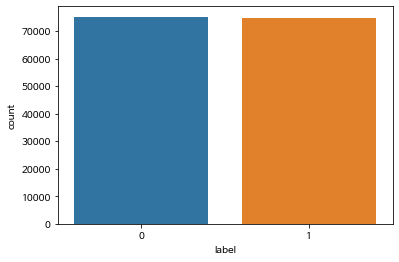

In [ ]:
sns.countplot(x="label", data=df);

## Target 값에 따른 텍스트 길이

In [ ]:
df['text_lengths'] = df['document'].str.len()
df.head()

,id,document,label,text_lengths
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19.0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33.0
2,10265843,너무재밓었다그래서보는것을추천한다,0,17.0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29.0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61.0


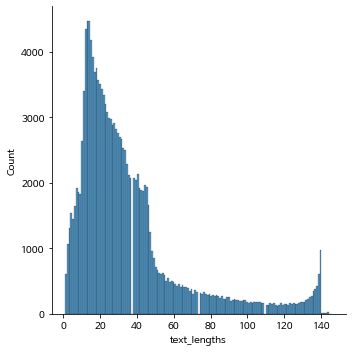

In [ ]:
sns.displot(x='text_lengths', data=df);

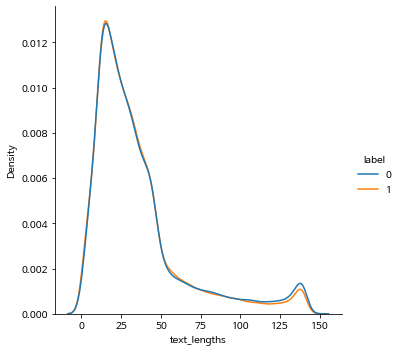

In [ ]:
sns.displot(x='text_lengths', hue='label', kind='kde', data=df);

# 텍스트 전처리

## Word Tokenization

### 한글 형태소 분석기 KONLPy 설치  
https://konlpy-ko.readthedocs.io/ko/v0.4.3/install/#id2  
https://alliswellv2030.tistory.com/2

In [ ]:
from konlpy.tag import Okt 
# Okt 트위터에서 만든 형태소 분석기
# 룰 베이스를 통해 함.
okt = Okt()

In [ ]:
text = df["document"][10]
print(text)

걍인피니트가짱이다.진짜짱이다♥


In [ ]:
# 단어 + 형태소
print(okt.pos(text))

[('걍', 'Adverb'), ('인피니트', 'Noun'), ('가', 'Josa'), ('짱', 'Noun'), ('이다', 'Josa'), ('.', 'Punctuation'), ('진짜', 'Noun'), ('짱', 'Suffix'), ('이다', 'Josa'), ('♥', 'Foreign')]


In [ ]:
# 단어 
print(okt.morphs(text))

['걍', '인피니트', '가', '짱', '이다', '.', '진짜', '짱', '이다', '♥']


### 특수 문자 제거

In [ ]:
df['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

In [ ]:
df['document'].str.replace('[^가-힣ㄱ-ㅎㅏ-ㅣA-Za-z]', '')

0                                             아더빙진짜짜증나네요목소리
1                                   흠포스터보고초딩영화줄오버연기조차가볍지않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                      교도소이야기구먼솔직히재미는없다평점조정
4         사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...
                                ...                        
149995                                         인간이문제지소는뭔죄인가
149996                                             평점이너무낮아서
149997                              이게뭐요한국인은거들먹거리고필리핀혼혈은착하다
149998                                청춘영화의최고봉방황과우울했던날들의자화상
149999                                   한국영화최초로수간하는내용이담긴영화
Name: document, Length: 150000, dtype: object

In [ ]:
df['document_cleaned'] = df['document'].str.replace('[^가-힣ㄱ-ㅎㅏ-ㅣA-Za-z]', '')
# 한글하고 영어만 남기겠다는 뜻. 숫자도 다 지웠다.
df.head(20)

,id,document,label,text_lengths,document_cleaned
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19.0,아더빙진짜짜증나네요목소리
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33.0,흠포스터보고초딩영화줄오버연기조차가볍지않구나
2,10265843,너무재밓었다그래서보는것을추천한다,0,17.0,너무재밓었다그래서보는것을추천한다
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29.0,교도소이야기구먼솔직히재미는없다평점조정
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61.0,사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0,45.0,막걸음마뗀세부터초등학교학년생인살용영화ㅋㅋㅋ별반개도아까움
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0,21.0,원작의긴장감을제대로살려내지못했다
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0,86.0,별반개도아깝다욕나온다이응경길용우연기생활이몇년인지정말발로해도그것보단낫겟다납치감금만반복...
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1,22.0,액션이없는데도재미있는몇안되는영화
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1,45.0,왜케평점이낮은건데꽤볼만한데헐리우드식화려함에만너무길들여져있나


### Word Cloud

In [ ]:
from collections import Counter
from wordcloud import WordCloud

# 데이터 갯수 세주는 함수 Counter 
# WordCloud 만들어주는 함수 WordCloud

In [ ]:
total_words = []
for text in tqdm(df['document_cleaned'][:300]):
    total_words += okt.morphs(text)

print(len(total_words))
print(total_words[:10])

100%|██████████| 300/300 [00:14<00:00, 21.01it/s]


3845
['아더', '빙', '진짜', '짜증나네요', '목소리', '흠', '포스터', '보고', '초딩', '영화']


In [ ]:
# 한 글자 단어는 제거
final_words = [word for word in total_words if len(word) > 1]
print(len(final_words))
print(final_words[:10])

2606
['아더', '진짜', '짜증나네요', '목소리', '포스터', '보고', '초딩', '영화', '오버', '연기']


In [ ]:
# 단어 숫자 세기 
count = Counter(final_words)
# 전체 갯수를 세서 그 중에 빈도수가 높은 순서대로 100개만 추출하겠다.
tags = count.most_common(100)
print(tags)

[('영화', 88), ('정말', 24), ('연기', 21), ('너무', 20), ('진짜', 18), ('하고', 17), ('보고', 14), ('에서', 14), ('드라마', 12), ('이다', 11), ('감동', 11), ('ㅋㅋ', 11), ('시간', 11), ('평점', 10), ('사람', 10), ('이런', 10), ('으로', 10), ('없다', 9), ('완전', 9), ('입니다', 9), ('최고', 9), ('이영화', 9), ('느낌', 9), ('작품', 9), ('ㅡㅡ', 8), ('생각', 8), ('ㅠㅠ', 7), ('그냥', 7), ('같은', 7), ('하나', 7), ('사랑', 7), ('감독', 7), ('없는', 7), ('주인공', 7), ('정도', 7), ('스토리', 6), ('절대', 6), ('인데', 6), ('이네', 6), ('배우', 6), ('이건', 6), ('별로', 6), ('재미', 5), ('보다', 5), ('다시', 5), ('인가', 5), ('없음', 5), ('조금', 5), ('이나', 5), ('에선', 5), ('ㅜㅜ', 5), ('전개', 5), ('내용', 5), ('진심', 5), ('역시', 5), ('다그', 4), ('라고', 4), ('이라', 4), ('재미없다', 4), ('부터', 4), ('쓰레기', 4), ('이렇게', 4), ('매력', 4), ('없고', 4), ('합니다', 4), ('용이', 4), ('웃음', 4), ('자체', 4), ('무슨', 4), ('짜증', 4), ('이제', 4), ('설정', 4), ('명작', 4), ('하는', 4), ('기도', 4), ('장면', 4), ('포스터', 3), ('이야기', 3), ('했던', 3), ('ㅋㅋㅋ', 3), ('그것', 3), ('액션', 3), ('년대', 3), ('자극', 3), ('감성', 3), ('절제', 3), ('보면', 3), ('갈수록', 3), 

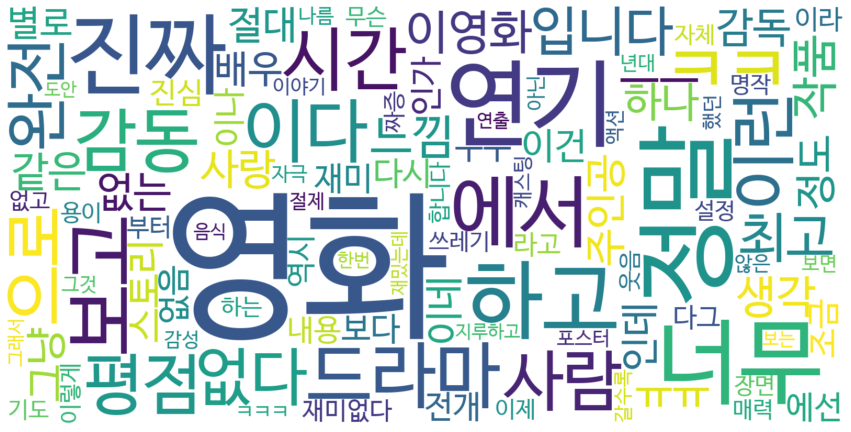

In [ ]:
# 워드 클라우드 그리기
wordcloud = WordCloud(font_path=font_path, 
                      background_color='white', 
                      width=1600, 
                      height=800).generate_from_frequencies(dict(tags))

fig = plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [36]:
# 이미지 마스킹
from PIL import Image

image_path = 'masking.png'

icon=Image.open(image_path)
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon, icon)
mask = np.array(mask)

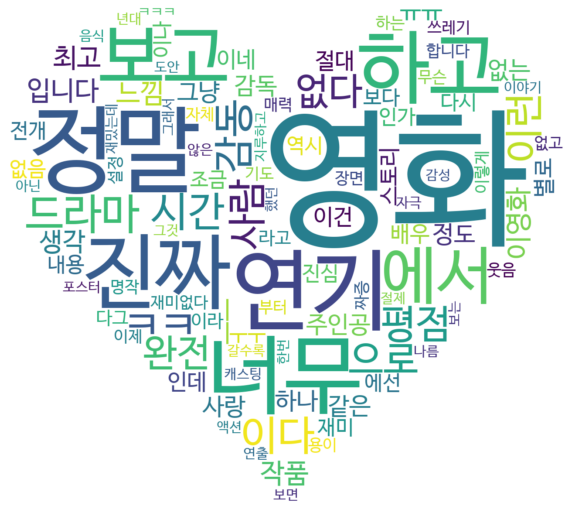

In [37]:
# 워드 클라우드 그리기
wordcloud = WordCloud(font_path=font_path, 
                      background_color='white', 
                      width=800, 
                      height=800, 
                      mask=mask).generate_from_frequencies(dict(tags))

fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()